In [1]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 2.0MB 5.1MB/s 
     |████████████████████████████████| 3.2MB 18.9MB/s 
     |████████████████████████████████| 890kB 34.9MB/s 
     |████████████████████████████████| 194kB 4.4MB/s 
     |████████████████████████████████| 245kB 5.9MB/s 
     |████████████████████████████████| 112kB 9.1MB/s 


In [2]:
import numpy as np
import random
import tqdm
from datasets import load_dataset
from datasets import load_metric
from transformers import pipeline, DistilBertForSequenceClassification, Trainer, TrainingArguments

from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# from alibi.explainers import IntegratedGradients

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import load_model
# Tokenizing and Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [4]:
# load dataset
pubhealth = load_dataset('health_fact')

Using custom data configuration default


Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/f6edecc77e6780a21be2f0a8882c78808b1c1a4c1f50e717a5acd1d5a34af76a. Subsequent calls will reuse this data.


(array([5.824e+03, 3.264e+03, 5.480e+02, 1.260e+02, 4.400e+01, 1.300e+01,
        6.000e+00, 5.000e+00, 0.000e+00, 2.000e+00]),
 array([1.0000e+00, 7.0760e+02, 1.4142e+03, 2.1208e+03, 2.8274e+03,
        3.5340e+03, 4.2406e+03, 4.9472e+03, 5.6538e+03, 6.3604e+03,
        7.0670e+03]),
 <a list of 10 Patch objects>)

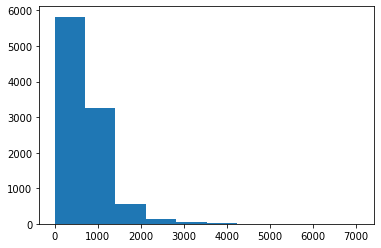

In [ ]:
# plot text length
train_length = [len(text.split(" ")) for text in pubhealth['train']['main_text']]
plt.hist(train_length)

In [5]:
# fit the tokenizer
max_len = 300
embedding_vector_length = 64

train_text = pubhealth['train']['main_text']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# save tokenizer to a pickle file
import pickle
with open ('tokenizer.pkl', 'wb') as f:
  pickle.dump(tokenizer, f)

In [6]:
def preprocess_text(tokenizer,text):
  """
  Args:
    tokenizer: keras tokenizer object
    text(list): list of strings of texts to make predictions on
  
  Return
    padded_sequence (np.array): shape [n_examples, maxlen] 

  """
  encoded_docs = tokenizer.texts_to_sequences(text)
  padded_sequence= pad_sequences(encoded_docs, maxlen=300)
  return padded_sequence


In [7]:
padded_sequence_train = preprocess_text(tokenizer,pubhealth['train']['main_text'])
padded_sequence_valid = preprocess_text(tokenizer,pubhealth['validation']['main_text'])

In [8]:
# one hot encode labels
from keras.utils import np_utils
train_labels = np_utils.to_categorical(pubhealth['train']['label'])
valid_labels = np_utils.to_categorical(pubhealth['validation']['label'])

In [11]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding


model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) 
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 64)           8292608   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 300, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 204       
Total params: 8,315,812
Trainable params: 8,315,812
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
n_epochs = 5
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(padded_sequence_train,train_labels,epochs=n_epochs, batch_size=64,validation_data=(padded_sequence_valid,valid_labels))

Epoch 1/5
154/154 [==============================] - 98s 607ms/step - loss: 1.1721 - accuracy: 0.4953 - val_loss: 0.8945 - val_accuracy: 0.6457
Epoch 2/5
154/154 [==============================] - 91s 592ms/step - loss: 0.8218 - accuracy: 0.6679 - val_loss: 0.8436 - val_accuracy: 0.6514
Epoch 3/5
154/154 [==============================] - 90s 588ms/step - loss: 0.6627 - accuracy: 0.7517 - val_loss: 0.8442 - val_accuracy: 0.6539
Epoch 4/5
154/154 [==============================] - 89s 575ms/step - loss: 0.4923 - accuracy: 0.8212 - val_loss: 0.9225 - val_accuracy: 0.6841
Epoch 5/5
154/154 [==============================] - 88s 573ms/step - loss: 0.3675 - accuracy: 0.8783 - val_loss: 1.1489 - val_accuracy: 0.6694


In [ ]:
model.save(f'drive/MyDrive/cs329s/lstm_token300_dim32_softmax')

INFO:tensorflow:Assets written to: drive/MyDrive/cs329s/lstm_token300_dim32_softmax/assets


In [15]:
model = keras.models.load_model('drive/MyDrive/cs329s/lstm_token300_dim32_softmax.h5')

In [20]:
padded_sequence_test = preprocess_text(tokenizer,pubhealth['test']['main_text'])
test_labels = pubhealth['test']['label']

In [21]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [18]:
pred = model.predict(padded_sequence_test)

In [22]:
compute_metrics(pred,test_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.6647773279352227,
 'f1': 0.38936825733853264,
 'precision': 0.44609903729751543,
 'recall': 0.3818555690644757}